First we need to import the necessary libraries. These include the following:
- NumPy
- Sci-Kit learn dependancies
- MatPlotLib

In [60]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

Next step is to load the iris dataset and then divide them into features and target in the conventional manner using 'X' and 'y'.

In [61]:
iris = load_iris()
X = iris.data
y = iris.target
# 4 feaures: sepal length, sepal width, petal length, petal width 
# Labels: 0, 1, 2 {setosa, versicolor, virginica}

print("Feature Shape: ", X.shape)
print("Target Shape: ", y.shape)

Feature Shape:  (150, 4)
Target Shape:  (150,)


Now we need to preprocess the data by splitting the dataset into 60% training and 40% testing. And then implement the three preprocessing approaches:
- Unprocessed data (simply copying)
- Normalisation (min-max scaling)
- Standardisation (z-score normalisation)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

def to_one_hot(labels, num_classes):
    return np.eye(num_classes)[labels]

y_train_onehot = to_one_hot(y_train, 3)
y_test_onehot = to_one_hot(y_test, 3)

X_train_raw = X_train.copy()
X_test_raw = X_test.copy()

def normalize(X):
    return (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)

def standardize(X):
    return (X - X.mean(axis=0)) / X.std(axis=0)

X_train_std = standardize(X_train)
X_test_std = normalize(X_test)

print("Training set shape (raw):", X_train_raw.shape)
print("Test set shape (normalized):", X_test_norm.shape)
print("Test set shape (standardized):", X_test_std.shape)
print("Training labels one-hot shape:", y_train_onehot.shape)

Training set shape (raw): (90, 4)
Test set shape (normalized): (60, 4)
Test set shape (standardized): (60, 4)
Training labels one-hot shape: (90, 3)


Now we need to write the Softmax function so that we can implement. We will use NumPy for this for the math behind it.

In [63]:
def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True)) # for numerical stability
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

# testing
test_logits = np.array([[1.0, 2.0, 3.0] , [1.0, 1.0, 1.0]])
print("Softmax testing output: ", softmax(test_logits))

Softmax testing output:  [[0.09003057 0.24472847 0.66524096]
 [0.33333333 0.33333333 0.33333333]]


Now we have to Implement the multiclass Logistic Regression, which invlolves several substeps.

In [64]:
class LogisticRegressionMulti:
    def __init__(self, num_features, num_classes, learning_rate=0.01):
        self.W = np.zeros((num_features, num_classes))  # Weights
        self.b = np.zeros((1, num_classes))  # Biases
        self.lr = learning_rate
    
    def predict_proba(self, X):
        logits = np.dot(X, self.W) + self.b
        return softmax(logits)
    
    def loss(self, X, y_onehot):
        m = X.shape[0]
        y_hat = self.predict_proba(X)
        epsilon = 1e-15
        y_hat = np.clip(y_hat, epsilon, 1 - epsilon)
        return -np.sum(y_onehot * np.log(y_hat)) / m
    
    def gradient_descent(self, X, y_onehot, epochs=100):
        losses = []
        m = X.shape[0]
        for epoch in range(epochs):
            y_hat = self.predict_proba(X)
            error = y_hat - y_onehot
            dW = np.dot(X.T, error) / m
            db = np.sum(error, axis=0, keepdims=True) / m
            self.W -= self.lr * dW
            self.b -= self.lr * db
            loss = self.loss(X, y_onehot)
            losses.append(loss)
            if epoch % 50 == 0:
                print(f"Epoch {epoch}, Loss: {loss}")
        return losses
    
    def sgd(self, X, y_onehot, epochs=100, batch_size=1):
        losses = []
        m = X.shape[0]
        for epoch in range(epochs):
            indices = np.random.permutation(m)
            X_shuffled = X[indices]
            y_shuffled = y_onehot[indices]
            for i in range(0, m, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                y_hat = self.predict_proba(X_batch)
                error = y_hat - y_batch
                dW = np.dot(X_batch.T, error) / batch_size
                db = np.sum(error, axis=0, keepdims=True) / batch_size
                self.W -= self.lr * dW
                self.b -= self.lr * db
            loss = self.loss(X, y_onehot)
            losses.append(loss)
            if epoch % 50 == 0:
                print(f"Epoch {epoch}, Loss: {loss}")
        return losses
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

# Train models for all three preprocessing approaches
datasets = {
    "Raw": (X_train_raw, X_test_raw),
    "Normalized": (X_train_norm, X_test_norm),
    "Standardized": (X_train_std, X_test_std)
}

gd_losses = {}
sgd_losses = {}

for name, (X_tr, X_te) in datasets.items():
    print(f"\nTraining on {name} data with Gradient Descent")
    model_gd = LogisticRegressionMulti(num_features=4, num_classes=3, learning_rate=0.1)
    gd_losses[name] = model_gd.gradient_descent(X_tr, y_train_onehot, epochs=200)
    
    print(f"Training on {name} data with SGD")
    model_sgd = LogisticRegressionMulti(num_features=4, num_classes=3, learning_rate=0.1)
    sgd_losses[name] = model_sgd.sgd(X_tr, y_train_onehot, epochs=200)


Training on Raw data with Gradient Descent
Epoch 0, Loss: 1.037724043249649
Epoch 50, Loss: 0.692804880142668
Epoch 100, Loss: 0.5226483214368891
Epoch 150, Loss: 0.3740541597883563
Training on Raw data with SGD
Epoch 0, Loss: 3.4281208167024837
Epoch 50, Loss: 0.09473185914551129
Epoch 100, Loss: 0.1198904418385551
Epoch 150, Loss: 0.08068580464322912

Training on Normalized data with Gradient Descent
Epoch 0, Loss: 1.089744507577178
Epoch 50, Loss: 0.8708438798078959
Epoch 100, Loss: 0.7509986508604881
Epoch 150, Loss: 0.6720168028147256
Training on Normalized data with SGD
Epoch 0, Loss: 0.7707093146641463
Epoch 50, Loss: 0.20415697545242723
Epoch 100, Loss: 0.14997659973462482
Epoch 150, Loss: 0.12347572040738329

Training on Standardized data with Gradient Descent
Epoch 0, Loss: 1.01220137781327
Epoch 50, Loss: 0.4111568961612368
Epoch 100, Loss: 0.34031977907273264
Epoch 150, Loss: 0.300415218888675
Training on Standardized data with SGD
Epoch 0, Loss: 0.35149364472649963
Epoch 

In [65]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} - Accuracy: {acc}")
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=iris.target_names))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

learning_rates = {
    "Raw": 0.5,
    "Normalized": 0.1,
    "Standardized": 0.05
}
lr = learning_rates[name]

Evaluate Raw (GD)

In [66]:
model_gd = LogisticRegressionMulti(num_features=4, num_classes=3, learning_rate=lr)
model_gd.gradient_descent(X_train_raw, y_train_onehot, epochs=200)
evaluate_model(model_gd, X_test_raw, y_test, "Raw (GD)")

Epoch 0, Loss: 1.0412538364936252
Epoch 50, Loss: 0.5650621177293996
Epoch 100, Loss: 0.46585341584816803
Epoch 150, Loss: 0.41236389933046524


[np.float64(1.0412538364936252),
 np.float64(1.0148973622761317),
 np.float64(0.9901804035424612),
 np.float64(0.966854569638503),
 np.float64(0.9448481816221349),
 np.float64(0.9240937100335913),
 np.float64(0.9045228212365184),
 np.float64(0.8860673460562039),
 np.float64(0.868660193003332),
 np.float64(0.852236073396363),
 np.float64(0.8367320507825802),
 np.float64(0.8220879365539635),
 np.float64(0.808246552833415),
 np.float64(0.7951538844349824),
 np.float64(0.7827591408232167),
 np.float64(0.7710147472476501),
 np.float64(0.7598762819228351),
 np.float64(0.7493023736244985),
 np.float64(0.7392545716100644),
 np.float64(0.729697197492935),
 np.float64(0.7205971866803326),
 np.float64(0.7119239252524359),
 np.float64(0.7036490867133546),
 np.float64(0.6957464718613939),
 np.float64(0.6881918540772283),
 np.float64(0.6809628315808494),
 np.float64(0.6740386876288458),
 np.float64(0.667400259182495),
 np.float64(0.6610298142476716),
 np.float64(0.6549109378468381),
 np.float64(0.64


Raw (GD) - Accuracy: 0.9833333333333333
Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        23
  versicolor       1.00      0.95      0.97        19
   virginica       0.95      1.00      0.97        18

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60

Confusion Matrix:
 [[23  0  0]
 [ 0 18  1]
 [ 0  0 18]]


Evaluate Raw (SGD)

In [67]:
model_sgd = LogisticRegressionMulti(num_features=4, num_classes=3, learning_rate=lr)
model_sgd.sgd(X_train_raw, y_train_onehot, epochs=200)
evaluate_model(model_sgd, X_test_raw, y_test, "Raw (SGD)")

Epoch 0, Loss: 1.3537002424964357
Epoch 50, Loss: 0.6132470571620589
Epoch 100, Loss: 0.0800560680180588
Epoch 150, Loss: 0.7154257091454752


[np.float64(1.3537002424964357),
 np.float64(1.5970438045221829),
 np.float64(1.028818587905629),
 np.float64(0.32230954945296697),
 np.float64(0.3196443048096437),
 np.float64(0.23111751703529457),
 np.float64(0.4084938303495567),
 np.float64(0.384192058818278),
 np.float64(0.909394278192741),
 np.float64(0.43842787247718307),
 np.float64(0.20282488620008318),
 np.float64(0.186275641467373),
 np.float64(0.15269462862306235),
 np.float64(0.23421097872295799),
 np.float64(0.31599315000449146),
 np.float64(0.19109762769157565),
 np.float64(0.1340218055132411),
 np.float64(1.0888844388962293),
 np.float64(0.1384288925304971),
 np.float64(0.24812455170954448),
 np.float64(0.3069395714950738),
 np.float64(0.4561125201632359),
 np.float64(0.7248144788707137),
 np.float64(0.15313540881221696),
 np.float64(0.11971178846772185),
 np.float64(0.4751965006483025),
 np.float64(0.10463524082076413),
 np.float64(0.4293569097482885),
 np.float64(0.29952181543048906),
 np.float64(0.10108945644891318),



Raw (SGD) - Accuracy: 0.9333333333333333
Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        23
  versicolor       0.83      1.00      0.90        19
   virginica       1.00      0.78      0.88        18

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60

Confusion Matrix:
 [[23  0  0]
 [ 0 19  0]
 [ 0  4 14]]


Evaluate Normalized (GD)

In [68]:
model_gd = LogisticRegressionMulti(num_features=4, num_classes=3, learning_rate=lr)
model_gd.gradient_descent(X_train_norm, y_train_onehot, epochs=200)
evaluate_model(model_gd, X_test_norm, y_test, "Normalized (GD)")

Epoch 0, Loss: 1.0941412014744005
Epoch 50, Loss: 0.9580547071094812
Epoch 100, Loss: 0.8725402060794819
Epoch 150, Loss: 0.8056786089218969


[np.float64(1.0941412014744005),
 np.float64(1.0898146502767436),
 np.float64(1.0856238858614256),
 np.float64(1.0815607282542445),
 np.float64(1.077617530147637),
 np.float64(1.0737871425510699),
 np.float64(1.0700628825493381),
 np.float64(1.0664385030560113),
 np.float64(1.062908164452579),
 np.float64(1.059466408007609),
 np.float64(1.0561081309743112),
 np.float64(1.052828563269196),
 np.float64(1.0496232456388717),
 np.float64(1.0464880092264277),
 np.float64(1.0434189564532204),
 np.float64(1.0404124431361614),
 np.float64(1.0374650617648131),
 np.float64(1.0345736258666531),
 np.float64(1.0317351553928098),
 np.float64(1.0289468630603493),
 np.float64(1.0262061415908268),
 np.float64(1.0235105517882914),
 np.float64(1.0208578114032396),
 np.float64(1.0182457847321846),
 np.float64(1.0156724729055029),
 np.float64(1.013136004819079),
 np.float64(1.010634628667971),
 np.float64(1.0081667040428866),
 np.float64(1.0057306945526783),
 np.float64(1.0033251609383689),
 np.float64(1.00


Normalized (GD) - Accuracy: 0.7166666666666667
Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        23
  versicolor       1.00      0.11      0.19        19
   virginica       0.51      1.00      0.68        18

    accuracy                           0.72        60
   macro avg       0.84      0.70      0.62        60
weighted avg       0.85      0.72      0.65        60

Confusion Matrix:
 [[23  0  0]
 [ 0  2 17]
 [ 0  0 18]]


Normalized (SGD)

In [69]:
model_sgd = LogisticRegressionMulti(num_features=4, num_classes=3, learning_rate=lr)
model_sgd.sgd(X_train_norm, y_train_onehot, epochs=200)
evaluate_model(model_sgd, X_test_norm, y_test, "Normalized (SGD)")

Epoch 0, Loss: 0.9184182341733375
Epoch 50, Loss: 0.27546427669692464
Epoch 100, Loss: 0.20784609186338562
Epoch 150, Loss: 0.17122924242982437


[np.float64(0.9184182341733375),
 np.float64(0.7731765411503673),
 np.float64(0.6985289148003523),
 np.float64(0.6395602066252978),
 np.float64(0.6100553281047167),
 np.float64(0.5735259968008546),
 np.float64(0.5358426069931047),
 np.float64(0.5123989396660911),
 np.float64(0.4935814894397857),
 np.float64(0.4771916243337821),
 np.float64(0.46272987361169304),
 np.float64(0.45847718901358303),
 np.float64(0.44374181206795477),
 np.float64(0.4285073749596532),
 np.float64(0.4201998654431526),
 np.float64(0.4103628383143065),
 np.float64(0.40302677452165736),
 np.float64(0.39516107912917176),
 np.float64(0.38772073904926524),
 np.float64(0.3839122213019344),
 np.float64(0.3830728106472484),
 np.float64(0.3792562792379777),
 np.float64(0.36919276773853565),
 np.float64(0.35913666463152194),
 np.float64(0.356384098099145),
 np.float64(0.35671321166510406),
 np.float64(0.3463112368006315),
 np.float64(0.3490533510997619),
 np.float64(0.3464765282572424),
 np.float64(0.33590211987564084),
 


Normalized (SGD) - Accuracy: 0.9833333333333333
Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        23
  versicolor       0.95      1.00      0.97        19
   virginica       1.00      0.94      0.97        18

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60

Confusion Matrix:
 [[23  0  0]
 [ 0 19  0]
 [ 0  1 17]]


Evaluate Standardized (GD)

In [70]:
model_gd = LogisticRegressionMulti(num_features=4, num_classes=3, learning_rate=lr)
model_gd.gradient_descent(X_train_std, y_train_onehot, epochs=200)
evaluate_model(model_gd, X_test_std, y_test, "Standardized (GD)")

Epoch 0, Loss: 1.0543898703040533
Epoch 50, Loss: 0.49993998727804456
Epoch 100, Loss: 0.4131092239504108
Epoch 150, Loss: 0.37007008277670367


[np.float64(1.0543898703040533),
 np.float64(1.0140425171236287),
 np.float64(0.9772332168673421),
 np.float64(0.9436383663729692),
 np.float64(0.9129523211623081),
 np.float64(0.8848903711277377),
 np.float64(0.8591903428945854),
 np.float64(0.8356130841433387),
 np.float64(0.81394209656728),
 np.float64(0.7939825654880653),
 np.float64(0.7755599985130652),
 np.float64(0.7585186434802108),
 np.float64(0.7427198144510255),
 np.float64(0.7280402177673931),
 np.float64(0.7143703399368333),
 np.float64(0.7016129355807706),
 np.float64(0.6896816362424355),
 np.float64(0.6784996885035739),
 np.float64(0.6679988215257114),
 np.float64(0.6581182388232715),
 np.float64(0.6488037259604427),
 np.float64(0.6400068642814281),
 np.float64(0.6316843402334462),
 np.float64(0.6237973399561277),
 np.float64(0.6163110193283414),
 np.float64(0.6091940404033876),
 np.float64(0.6024181660048439),
 np.float64(0.5959579051197926),
 np.float64(0.5897902025653594),
 np.float64(0.5838941671905328),
 np.float64(


Standardized (GD) - Accuracy: 0.3
Classification Report:
               precision    recall  f1-score   support

      setosa       0.00      0.00      0.00        23
  versicolor       0.00      0.00      0.00        19
   virginica       0.39      1.00      0.56        18

    accuracy                           0.30        60
   macro avg       0.13      0.33      0.19        60
weighted avg       0.12      0.30      0.17        60

Confusion Matrix:
 [[ 0 14  9]
 [ 0  0 19]
 [ 0  0 18]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Evaluate Standardized (SGD)

In [71]:
model_sgd = LogisticRegressionMulti(num_features=4, num_classes=3, learning_rate=lr)
model_sgd.sgd(X_train_std, y_train_onehot, epochs=200)
evaluate_model(model_sgd, X_test_std, y_test, "Standardized (SGD)")

Epoch 0, Loss: 0.4333043780178381
Epoch 50, Loss: 0.09343901122171844
Epoch 100, Loss: 0.07372499986402248
Epoch 150, Loss: 0.06557397559752874


[np.float64(0.4333043780178381),
 np.float64(0.35335376230954085),
 np.float64(0.3111947901042817),
 np.float64(0.28170624063852323),
 np.float64(0.2594338093092322),
 np.float64(0.24129490508158902),
 np.float64(0.2263217800015722),
 np.float64(0.2145528629523392),
 np.float64(0.20289443997304882),
 np.float64(0.19288189169585218),
 np.float64(0.18441442499044708),
 np.float64(0.17709401017596565),
 np.float64(0.17075682485448576),
 np.float64(0.1655520639446424),
 np.float64(0.15953971036075718),
 np.float64(0.15506189274117105),
 np.float64(0.15043210561945627),
 np.float64(0.14645376693712528),
 np.float64(0.14309354955846834),
 np.float64(0.13969348431341075),
 np.float64(0.13632596936013472),
 np.float64(0.13377412145523085),
 np.float64(0.1307902281467688),
 np.float64(0.1282933436178691),
 np.float64(0.12618118651840068),
 np.float64(0.12383712613900764),
 np.float64(0.12232392134793055),
 np.float64(0.11979862867701699),
 np.float64(0.11787084014217301),
 np.float64(0.11623233


Standardized (SGD) - Accuracy: 0.5833333333333334
Classification Report:
               precision    recall  f1-score   support

      setosa       0.00      0.00      0.00        23
  versicolor       0.43      1.00      0.60        19
   virginica       1.00      0.89      0.94        18

    accuracy                           0.58        60
   macro avg       0.48      0.63      0.51        60
weighted avg       0.44      0.58      0.47        60

Confusion Matrix:
 [[ 0 23  0]
 [ 0 19  0]
 [ 0  2 16]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

<Figure size 1200x800 with 0 Axes>

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Loss Curves for Different Preprocessing and Training Methods')

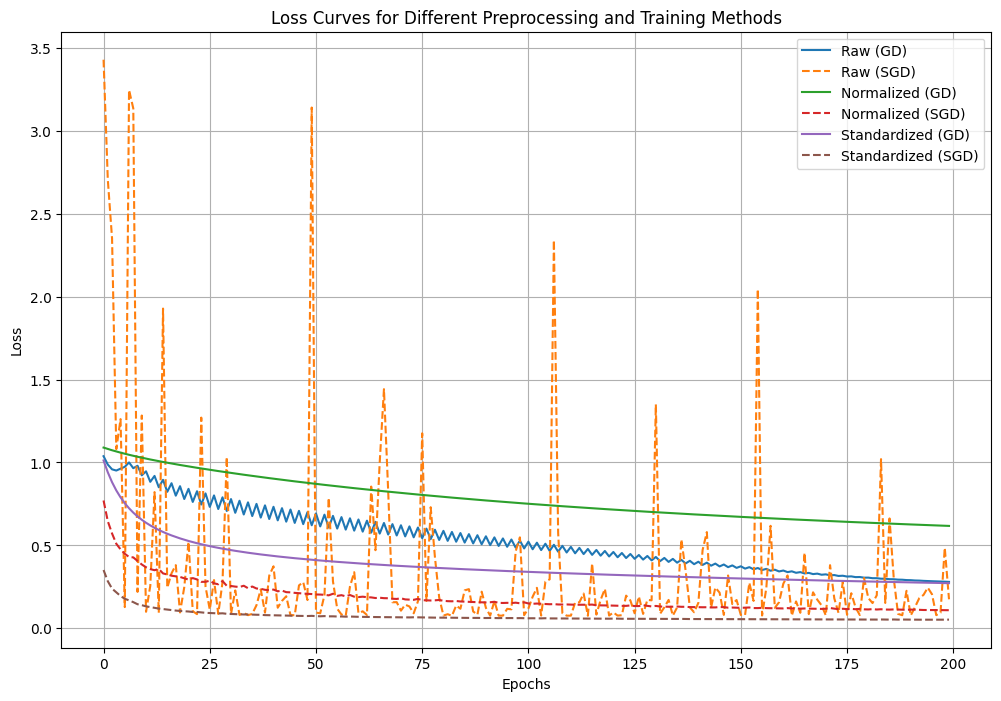

In [72]:
plt.figure(figsize=(12, 8))
for name in datasets.keys():
    plt.plot(gd_losses[name], label=f"{name} (GD)")
    plt.plot(sgd_losses[name], label=f"{name} (SGD)", linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves for Different Preprocessing and Training Methods")
plt.legend()
plt.grid(True)
plt.show()